In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util
from cartopy.util import add_cyclic_point

# import regionmask

import seaborn as sns

# Analysis
# import os
import time
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle
import scipy.stats as stats
import glob
import os 

# Import Ngl with pyn_env active 
# import Ngl

import metpy.calc as mpc
from metpy.units import units
from metpy.plots import Hodograph, SkewT

import warnings
warnings.filterwarnings('ignore')



In [2]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

In [3]:
## From Brian M. to use midpoints and work with years that 01 onwards
def open_cesm_dataset(fils):
    if isinstance(fils,list) and (len(fils)==1):
        ds = xr.open_dataset(fils[0], decode_times=False)
    elif isinstance(fils,list):
        ds = xr.open_mfdataset(fils, decode_times=False, combine='by_coords')
    else:
        ds = xr.open_dataset(fils, decode_times=False)
    assert 'time_bnds' in ds  # require time_bnds to derive average time
    bnd_dims = ds['time_bnds'].dims
    print(f"The time bounds dimension is {bnd_dims[1]}")
    time_correct = ds['time_bnds'].mean(dim=bnd_dims[1])
    time_correct.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time":time_correct})
    ds = xr.decode_cf(ds)
    return ds


In [4]:
def regrid_data(fromthis, tothis, method=1):
    """Regrid data using various different methods"""

    #Import necessary modules:
    import xarray as xr

    if method == 1:
        # kludgy: spatial regridding only, seems like can't automatically deal with time
        if 'time' in fromthis.coords:
            result = [fromthis.isel(time=t).interp_like(tothis) for t,time in enumerate(fromthis['time'])]
            result = xr.concat(result, 'time')
            return result
        else:
            return fromthis.interp_like(tothis)
    elif method == 2:
        newlat = tothis['lat']
        newlon = tothis['lon']
        coords = dict(fromthis.coords)
        coords['lat'] = newlat
        coords['lon'] = newlon
        return fromthis.interp(coords)
    elif method == 3:
        newlat = tothis['lat']
        newlon = tothis['lon']
        ds_out = xr.Dataset({'lat': newlat, 'lon': newlon})
        regridder = xe.Regridder(fromthis, ds_out, 'bilinear')
        return regridder(fromthis)
    elif method==4:
        # geocat
        newlat = tothis['lat']
        newlon = tothis['lon']
        result = geocat.comp.linint2(fromthis, newlon, newlat, False)
        result.name = fromthis.name
        
        return result

In [9]:
def preprocess_h0(ds):
    
    # ds         = cesm_correct_time(ds)
    # ds['time'] = ds.indexes['time'].to_datetimeindex()     
    
    ## Add a few shorthand variables 
    ds['windSpeedBot'] = (('time','lat','lon'),    
                                    np.sqrt(ds['U'].isel(lev=-1).values**2 + ds['V'].isel(lev=-1).values**2) )
    ds['windSpeedBot'].attrs['units']   = "m/s"
        
    return ds

In [10]:
def preprocess_h1(ds):
    
    # ds         = cesm_correct_time(ds)
    # ds['time'] = ds.indexes['time'].to_datetimeindex()     
    
    ## Add a few shorthand variables 
    ds['windSpeedBot'] = (('time','lat','lon'),    
                                    np.sqrt(ds['U'].isel(lev=-1).values**2 + ds['V'].isel(lev=-1).values**2) )
    ds['windSpeedBot'].attrs['units']   = "m/s"
        
    return ds

## Read in data 

These runs should all be 5 years, use the SE dycore and CAM6 physics. These are also all with modifications in place to output the *actual* stability-corrected U10 rather than U10n. 

In [11]:
dataDir = '/glade/campaign/cgd/tss/mdfowler/FluxProject/'

L32case = 'F2010climo.ne30pg3_ne30pg3_mg17.TestGustGlobal_Control_cam6_32L.outAdjustU10.001'
L48case = 'F2010climo.ne30pg3_ne30pg3_mg17.TestGustGlobal_Control_cam6_48L.outAdjustU10.001'
L58case = 'F2010climo.ne30pg3_ne30pg3_mg17.TestGustGlobal_Control_cam6_58L.outAdjustU10.001'



In [12]:
## Get lists of files 
L32files_h0 = np.sort(glob.glob(dataDir+L32case+'/atm/hist/'+'*cam.h0.000?-??.nc'))
L32files_h1 = np.sort(glob.glob(dataDir+L32case+'/atm/hist/'+'*cam.h1.000?-??-??*.nc'))

L48files_h0 = np.sort(glob.glob(dataDir+L48case+'/atm/hist/'+'*cam.h0.000?-??.nc'))
L48files_h1 = np.sort(glob.glob(dataDir+L48case+'/atm/hist/'+'*cam.h1.000?-??-??*.nc'))

L58files_h0 = np.sort(glob.glob(dataDir+L58case+'/atm/hist/'+'*cam.h0.000?-??.nc'))
L58files_h1 = np.sort(glob.glob(dataDir+L58case+'/atm/hist/'+'*cam.h1.000?-??-??*.nc'))


In [9]:
# ## Use Brian's script to update time 
# L32_h0 = open_cesm_dataset(list(L32files_h0))
# L32_h1 = open_cesm_dataset(list(L32files_h1))
# print('L32 cases opened')

# L48_h0 = open_cesm_dataset(list(L48files_h0))
# L48_h1 = open_cesm_dataset(list(L48files_h1))
# print('L48 cases opened')

# L58_h0 = open_cesm_dataset(list(L58files_h0))
# L58_h1 = open_cesm_dataset(list(L58files_h1))
# print('L58 cases opened')


The time bounds dimension is nbnd
The time bounds dimension is nbnd
The time bounds dimension is nbnd
The time bounds dimension is nbnd
The time bounds dimension is nbnd
The time bounds dimension is nbnd


In [13]:
# ## Drop first year 
# L32_h0 = L32_h0.isel(time=np.where(L32_h0['time.year']>1)[0])
# L32_h1 = L32_h1.isel(time=np.where(L32_h1['time.year']>1)[0])

# L48_h0 = L48_h0.isel(time=np.where(L48_h0['time.year']>1)[0])
# L48_h1 = L48_h1.isel(time=np.where(L48_h1['time.year']>1)[0])

# L58_h0 = L58_h0.isel(time=np.where(L58_h0['time.year']>1)[0])
# L58_h1 = L58_h1.isel(time=np.where(L58_h1['time.year']>1)[0])


In [13]:
## Load files 
L32_h0 = xr.open_mfdataset(L32files_h0,  preprocess=preprocess_h0, concat_dim='time', 
                            combine='nested', decode_times=True, 
                            data_vars='minimal')
L32_h1 = xr.open_mfdataset(L32files_h1,  preprocess=preprocess_h1, concat_dim='time', 
                            combine='nested', decode_times=True, 
                            data_vars='minimal')
print('Loaded L32 files: h0 and h1 datasets')


L48_h0 = xr.open_mfdataset(L48files_h0,  preprocess=preprocess_h0, concat_dim='time', 
                            combine='nested', decode_times=True, 
                            data_vars='minimal')
L48_h1 = xr.open_mfdataset(L48files_h1,  preprocess=preprocess_h1, concat_dim='time', 
                            combine='nested', decode_times=True, 
                            data_vars='minimal')
print('Loaded L48 files: h0 and h1 datasets')


L58_h0 = xr.open_mfdataset(L58files_h0,  preprocess=preprocess_h0, concat_dim='time', 
                            combine='nested', decode_times=True, 
                            data_vars='minimal')
L58_h1 = xr.open_mfdataset(L58files_h1,  preprocess=preprocess_h1, concat_dim='time', 
                            combine='nested', decode_times=True, 
                            data_vars='minimal')
print('Loaded L58 files: h0 and h1 datasets')


Loaded L32 files: h0 and h1 datasets
Loaded L48 files: h0 and h1 datasets
Loaded L58 files: h0 and h1 datasets


In [14]:
## Couldn't convert timeseries that's in years 0001-* to a datetime series, so manually updating this here 

L32_h0['time'] = L32_h0['time'].values - timedelta(days=15)
L48_h0['time'] = L48_h0['time'].values - timedelta(days=15)
L58_h0['time'] = L58_h0['time'].values - timedelta(days=15)

L32_h1['time'] = L32_h1['time'].values - timedelta(hours=12)
L48_h1['time'] = L48_h1['time'].values - timedelta(hours=12)
L58_h1['time'] = L58_h1['time'].values - timedelta(hours=12)


In [15]:
## A few observational files would be helpful too... 
obsDir = '/glade/p/cesm/amwg/amwg_diagnostics/obs_data/'

gpcp_jja = xr.open_dataset(obsDir+'GPCP_JJA_climo.nc', decode_times=False)   #PRECT in mm/day 
gpcp_djf = xr.open_dataset(obsDir+'GPCP_DJF_climo.nc', decode_times=False)   #PRECT in mm/day 

erai_jja = xr.open_dataset(obsDir+'ERAI_JJA_climo.nc', decode_times=False)   #PRECT in mm/day 
erai_djf = xr.open_dataset(obsDir+'ERAI_DJF_climo.nc', decode_times=False)   #PRECT in mm/day 


## What are the biases in each case?

In [16]:
def meanTimeAndRegion(DS,monStart,monEnd,yrMin,yrMax,
                      minLat,maxLat,minLon,maxLon): 
    
    iTime = np.where( (DS['time.month']>=monStart) & (DS['time.month']<=monEnd) & (DS['time.year']>=yrMin) & (DS['time.year']<=yrMax) )[0]
    iLat  = np.where( (DS['lat']>=minLat) & (DS['lat']<=maxLat) )[0]
    iLon  = np.where( (DS['lon']>=minLon) & (DS['lon']<=maxLon) )[0]

    selDS     = DS.isel(time=iTime, lat=iLat, lon=iLon).mean(dim='time')
    
    print('Min year in DS: ', np.nanmin(DS.isel(time=iTime, lat=iLat, lon=iLon)['time.year'].values))
    print('Max year in DS: ', np.nanmax(DS.isel(time=iTime, lat=iLat, lon=iLon)['time.year'].values))
    
    return selDS


In [17]:
## Select a range of years and 

monStart = 6
monEnd   = 8
yrMin    = 2
yrMax    = 5

## Tropical NW Pacific
minLat     = 5
maxLat     = 30
minLon     = 90
maxLon     = 145   # Original domain

# ## ~global
# minLat     = -80
# maxLat     = 80
# minLon     = 0
# maxLon     = 359   

sel_L32 = meanTimeAndRegion(L32_h1,monStart,monEnd,yrMin,yrMax,minLat,maxLat,minLon,maxLon).load()
sel_L48 = meanTimeAndRegion(L48_h1,monStart,monEnd,yrMin,yrMax,minLat,maxLat,minLon,maxLon).load()
sel_L58 = meanTimeAndRegion(L58_h1,monStart,monEnd,yrMin,yrMax,minLat,maxLat,minLon,maxLon).load()


## Select same region for obs comparison:
ilat = np.where( (erai_jja.lat.values>=minLat) & (erai_jja.lat.values<=maxLat) )[0]
ilon = np.where( (erai_jja.lon.values>=minLon) & (erai_jja.lon.values<=maxLon) )[0]
sel_erai_jja = erai_jja.isel(lat=ilat,lon=ilon)
sel_erai_djf = erai_djf.isel(lat=ilat,lon=ilon)

ilat2 = np.where( (gpcp_jja.lat.values>=minLat) & (gpcp_jja.lat.values<=maxLat) )[0]
ilon2 = np.where( (gpcp_jja.lon.values>=minLon) & (gpcp_jja.lon.values<=maxLon) )[0]
sel_gpcp_jja = gpcp_jja.isel(lat=ilat2,lon=ilon2)
sel_gpcp_djf = gpcp_djf.isel(lat=ilat2,lon=ilon2)



Min year in DS:  2
Max year in DS:  5
Min year in DS:  2
Max year in DS:  5
Min year in DS:  2
Max year in DS:  5


In [18]:
def plotBiases_regridded(obsDS, obsVar, obsMultiplier,
                         ds32, ds48, ds58, dsVar,
                         obsString, unitsString):
    
    ## Handle regridding the CAM data to obs grid
    # Get obs grid 
    obsGrid = obsDS[obsVar].isel(time=0).squeeze()*obsMultiplier

    # Now regrid the data
    regrid_ds32    = regrid_data(ds32, obsGrid, method=1)[dsVar]
    regrid_ds48    = regrid_data(ds48, obsGrid, method=1)[dsVar]
    regrid_ds58    = regrid_data(ds58, obsGrid, method=1)[dsVar]
    ## - - - - - - - - - - - - - - - - - - - - - - - - - -
    ## Get colorbar limits for raw data and for biases 
    maxRawVal = np.nanmax( [np.nanpercentile(obsGrid,     98),
                            np.nanpercentile(regrid_ds32, 98),
                            np.nanpercentile(regrid_ds48, 98), 
                            np.nanpercentile(regrid_ds58, 98)] )
    minRawVal = np.nanmin( [np.nanpercentile(obsGrid,      2),
                            np.nanpercentile(regrid_ds32,  2),
                            np.nanpercentile(regrid_ds48,  2), 
                            np.nanpercentile(regrid_ds58,  2)] )
    levsMap    = np.arange(minRawVal, maxRawVal, (maxRawVal-minRawVal)/100.0)
    
    
    ## - - - - - - - - - - - - - - - - - - - - - - - - - -
    ## Make cool plots of raw data 
    fig,axs = plt.subplots(2,4, figsize=(15,5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
    axs     = axs.ravel()
    fig.subplots_adjust(hspace=0.3)
    
    # Plot observations 
    contour_plot = axs[0].contourf(obsGrid.lon.values, obsGrid.lat.values, np.squeeze(obsGrid), 
                                    levsMap,
                                    cmap='gnuplot2',extend='both',
                                    transform=ccrs.PlateCarree())
    axs[0].coastlines()
    axs[0].set_extent([np.nanmin(obsGrid.lon.values)-2,np.nanmax(obsGrid.lon.values)+2,
                       np.nanmin(obsGrid.lat.values)-2,np.nanmax(obsGrid.lat.values)+2], crs=ccrs.PlateCarree())
    axs[0].set_title(obsString+obsVar)
    
    # Plot model data 
    contour_plot = axs[1].contourf(regrid_ds32.lon.values, regrid_ds32.lat.values, np.squeeze(regrid_ds32), 
                                    levsMap,
                                    cmap='gnuplot2',extend='both',
                                    transform=ccrs.PlateCarree())
    axs[1].coastlines()
    axs[1].set_extent([np.nanmin(regrid_ds32.lon.values)-2,np.nanmax(regrid_ds32.lon.values)+2,
                       np.nanmin(regrid_ds32.lat.values)-2,np.nanmax(regrid_ds32.lat.values)+2], crs=ccrs.PlateCarree())
    axs[1].set_title('L32se_cam6: '+dsVar)
    
    
    contour_plot = axs[2].contourf(regrid_ds48.lon.values, regrid_ds48.lat.values, np.squeeze(regrid_ds48), 
                                    levsMap,
                                    cmap='gnuplot2',extend='both',
                                    transform=ccrs.PlateCarree())
    axs[2].coastlines()
    axs[2].set_extent([np.nanmin(regrid_ds48.lon.values)-2,np.nanmax(regrid_ds48.lon.values)+2,
                       np.nanmin(regrid_ds48.lat.values)-2,np.nanmax(regrid_ds48.lat.values)+2], crs=ccrs.PlateCarree())
    axs[2].set_title('L48se_cam6: '+dsVar)
    # Add colorbar
    ax_position = axs[2].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.08, ax_position.width+0.2, 0.03])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
    cbar.set_label(unitsString,fontsize=11)
    
    
    contour_plot = axs[3].contourf(regrid_ds58.lon.values, regrid_ds58.lat.values, np.squeeze(regrid_ds58), 
                                    levsMap,
                                    cmap='gnuplot2',extend='both',
                                    transform=ccrs.PlateCarree())
    axs[3].coastlines()
    axs[3].set_extent([np.nanmin(regrid_ds58.lon.values)-2,np.nanmax(regrid_ds58.lon.values)+2,
                       np.nanmin(regrid_ds58.lat.values)-2,np.nanmax(regrid_ds58.lat.values)+2], crs=ccrs.PlateCarree())
    axs[3].set_title('L58se_cam6: '+dsVar)
    
    axs[4].set_visible(False)
        
    ## - - - - - - - - - - - - - - - - - - - - - - - - - -
    ## Make cool plots of biases 
    
    ## Plot difference 
    diffVar32 = np.squeeze(regrid_ds32) - np.squeeze(obsGrid)
    diffVar48 = np.squeeze(regrid_ds48) - np.squeeze(obsGrid)
    diffVar58 = np.squeeze(regrid_ds58) - np.squeeze(obsGrid)
    
    cMax = np.nanmax( [ np.nanpercentile(diffVar32, 98),
                        np.nanpercentile(diffVar48, 98), 
                        np.nanpercentile(diffVar58, 98)] )
    
    cMin = np.nanmin( [ np.nanpercentile(diffVar32,  2),
                        np.nanpercentile(diffVar48,  2), 
                        np.nanpercentile(diffVar58,  2)] )

    evenPoint = np.nanmax([abs(cMax),abs(cMin)]) 
    cStep     = (evenPoint*2)/100.0
    levsDiff  = np.arange(-evenPoint, (evenPoint+cStep), cStep ) 
    
    
    
    contour_plot = axs[5].contourf(diffVar32.lon.values, diffVar32.lat.values, np.squeeze(diffVar32), 
                                    levsDiff,
                                    cmap='bwr',extend='both',
                                    transform=ccrs.PlateCarree())
    axs[5].coastlines()
    axs[5].set_extent([np.nanmin(diffVar32.lon.values)-2,np.nanmax(diffVar32.lon.values)+2,
                       np.nanmin(diffVar32.lat.values)-2,np.nanmax(diffVar32.lat.values)+2], crs=ccrs.PlateCarree())
    axs[5].set_title('L32se_cam6 - '+obsString+': ')
    
    
    contour_plot = axs[6].contourf(diffVar48.lon.values, diffVar48.lat.values, np.squeeze(diffVar48), 
                                    levsDiff,
                                    cmap='bwr',extend='both',
                                    transform=ccrs.PlateCarree())
    axs[6].coastlines()
    axs[6].set_extent([np.nanmin(diffVar48.lon.values)-2,np.nanmax(diffVar48.lon.values)+2,
                       np.nanmin(diffVar48.lat.values)-2,np.nanmax(diffVar48.lat.values)+2], crs=ccrs.PlateCarree())
    axs[6].set_title('L48se_cam6 - '+obsString+': ')
    # Add colorbar
    ax_position = axs[6].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.08, ax_position.width+0.2, 0.03])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
    cbar.set_label(unitsString,fontsize=11)
    
    
    contour_plot = axs[7].contourf(diffVar58.lon.values, diffVar58.lat.values, np.squeeze(diffVar58), 
                                    levsDiff,
                                    cmap='bwr',extend='both',
                                    transform=ccrs.PlateCarree())
    axs[7].coastlines()
    axs[7].set_extent([np.nanmin(diffVar58.lon.values)-2,np.nanmax(diffVar58.lon.values)+2,
                       np.nanmin(diffVar58.lat.values)-2,np.nanmax(diffVar58.lat.values)+2], crs=ccrs.PlateCarree())
    axs[7].set_title('L58se_cam6 - '+obsString+': ')
    
    ## Pick a few points to look into more closely
    axs[5].plot(112, 16, 'go', markersize=4,transform=ccrs.PlateCarree())
    axs[6].plot(112, 16, 'go', markersize=4,transform=ccrs.PlateCarree())
    axs[7].plot(112, 16, 'go', markersize=4,transform=ccrs.PlateCarree())
    
    axs[5].plot(112, 13, 'gv', markersize=4,transform=ccrs.PlateCarree())
    axs[6].plot(112, 13, 'gv', markersize=4,transform=ccrs.PlateCarree())
    axs[7].plot(112, 13, 'gv', markersize=4,transform=ccrs.PlateCarree())
    
    axs[5].plot(135, 12, 'gs', markersize=4,transform=ccrs.PlateCarree())
    axs[6].plot(135, 12, 'gs', markersize=4,transform=ccrs.PlateCarree())
    axs[7].plot(135, 12, 'gs', markersize=4,transform=ccrs.PlateCarree())
    
    axs[5].plot(92, 10, 'g^', markersize=4,transform=ccrs.PlateCarree())
    axs[6].plot(92, 10, 'g^', markersize=4,transform=ccrs.PlateCarree())
    axs[7].plot(92, 10, 'g^', markersize=4,transform=ccrs.PlateCarree())
    
        
    return axs

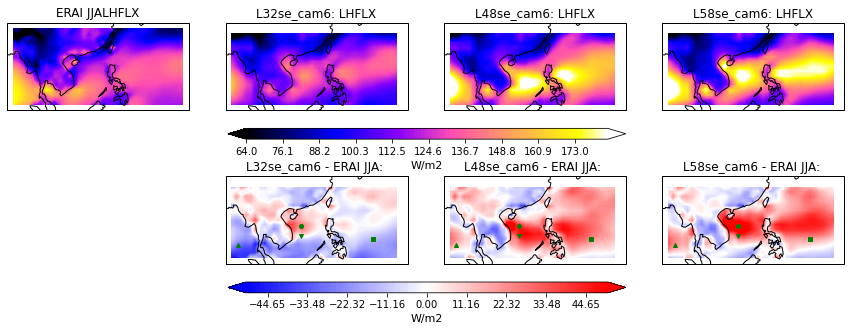

In [19]:
axs = plotBiases_regridded(sel_erai_jja, 'LHFLX', 1,
                           sel_L32, sel_L48, sel_L58, 'LHFLX',
                           'ERAI JJA', 'W/m2')


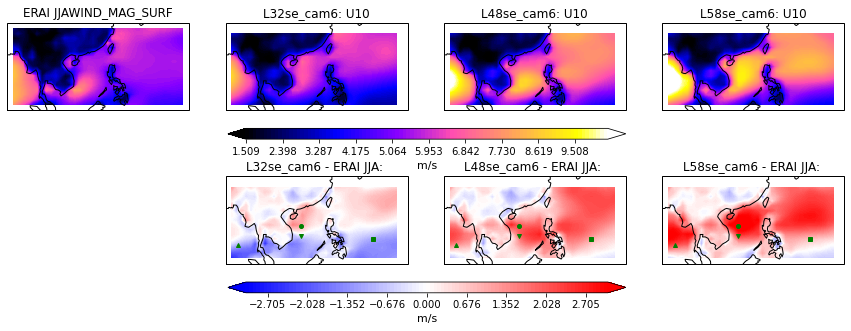

In [153]:
axs = plotBiases_regridded(sel_erai_jja, 'WIND_MAG_SURF', 1,
                           sel_L32, sel_L48, sel_L58, 'U10',
                           'ERAI JJA', 'm/s')


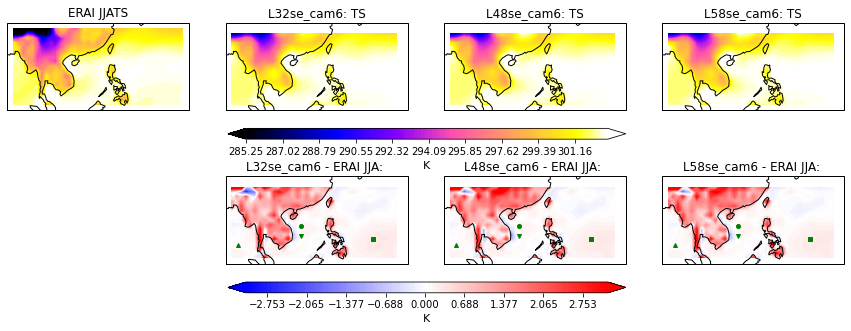

In [173]:
axs = plotBiases_regridded(sel_erai_jja, 'TS', 1,
                           sel_L32, sel_L48, sel_L58, 'TS',
                           'ERAI JJA', 'K')


In [20]:
## Select these points... 

## Get points that are already averaged in time too
IOpoint_selL32     = sel_L32.sel(lon=92,lat=10, method='nearest')
IOpoint_selL48     = sel_L48.sel(lon=92,lat=10, method='nearest')
IOpoint_selL58     = sel_L58.sel(lon=92,lat=10, method='nearest')

SCSpointTop_selL32 = sel_L32.sel(lon=112,lat=16, method='nearest')
SCSpointTop_selL48 = sel_L48.sel(lon=112,lat=16, method='nearest')
SCSpointTop_selL58 = sel_L58.sel(lon=112,lat=16, method='nearest')

SCSpointBot_selL32 = sel_L32.sel(lon=112,lat=13, method='nearest')
SCSpointBot_selL48 = sel_L48.sel(lon=112,lat=13, method='nearest')
SCSpointBot_selL58 = sel_L58.sel(lon=112,lat=13, method='nearest')

WPpoint_selL32     = sel_L32.sel(lon=135,lat=12, method='nearest')
WPpoint_selL48     = sel_L48.sel(lon=135,lat=12, method='nearest')
WPpoint_selL58     = sel_L58.sel(lon=135,lat=12, method='nearest')



In [113]:
IOpoint_erai     = sel_erai_jja.sel(lon=92,lat=10, method='nearest')
SCSpointTop_erai = sel_erai_jja.sel(lon=112,lat=16, method='nearest')
SCSpointBot_erai = sel_erai_jja.sel(lon=112,lat=13, method='nearest')
WPpoint_erai     = sel_erai_jja.sel(lon=135,lat=12, method='nearest')


**Vertical profiles?**

In [104]:
def plotProfiles(L32ds, L48ds, L58ds, dsVarName,
                 obsDS, obsVarName, obsMult, 
                 xMin, xMax, yBot, yTop, 
                 titleString):
    
    fig,axs = plt.subplots(1,1,figsize=(6,5))
    
    axs.plot(L32ds[dsVarName].values, L32ds.lev.values, color='mediumblue', label='L32')
    axs.plot(L48ds[dsVarName].values, L48ds.lev.values, color='dodgerblue', label='L48')
    axs.plot(L58ds[dsVarName].values, L58ds.lev.values, color='turquoise', label='L58')
    
    axs.plot(np.squeeze(obsDS[obsVarName].values)*obsMult, obsDS.lev.values,'k--', markersize=5, alpha=0.7, label='ERAI')

    axs.legend()
    axs.invert_yaxis()

    axs.set_xlabel(L32_h1[dsVarName].units)
    axs.set_ylabel(L32_h1['lev'].units)
    axs.set_title(dsVarName+': '+titleString)

    axs.set_ylim([yBot, yTop])
    axs.set_xlim([xMin, xMax])

    
    return

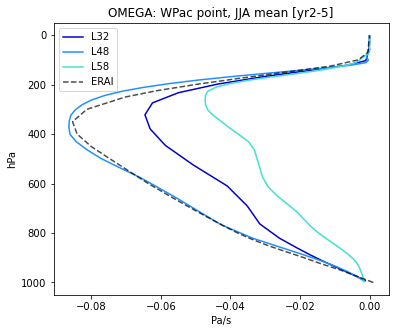

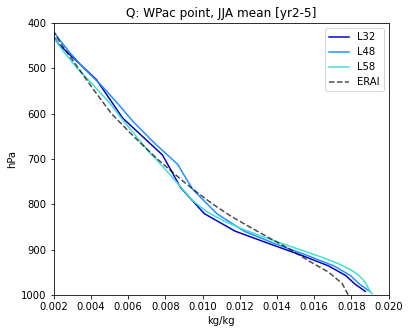

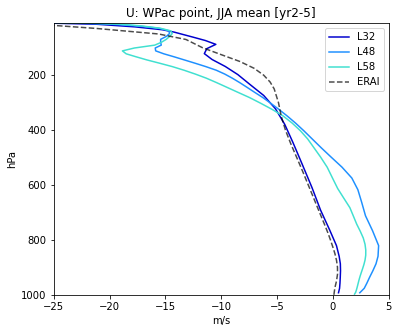

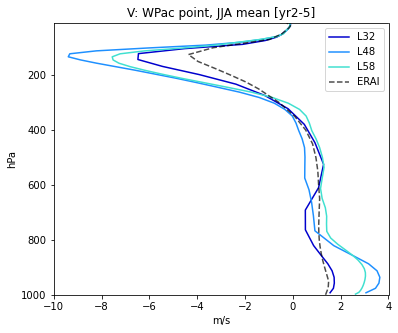

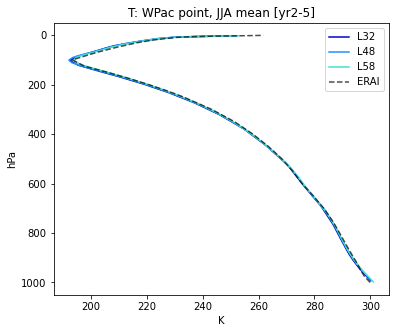

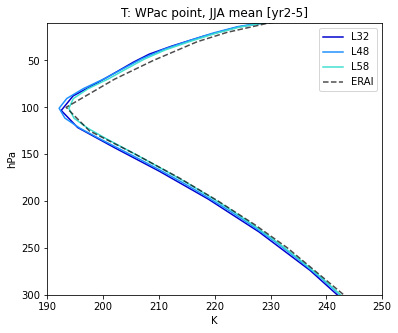

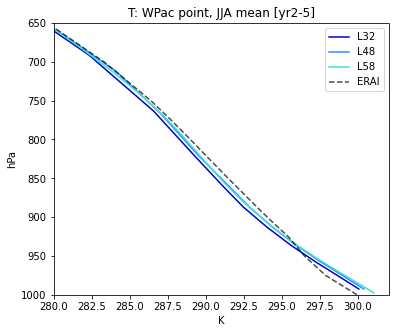

In [112]:

plotProfiles(WPpoint_selL32, WPpoint_selL48, WPpoint_selL58, 'OMEGA',
             WPpoint_erai, 'OMEGA', 100.0/86400.0, 
             None, None, None, None, 
             'WPac point, JJA mean [yr2-5]')

plotProfiles(WPpoint_selL32, WPpoint_selL48, WPpoint_selL58, 'Q',
             WPpoint_erai, 'SHUM', 1e-3, 
             0.002, 0.02, 1000, 400, 
             'WPac point, JJA mean [yr2-5]')

plotProfiles(WPpoint_selL32, WPpoint_selL48, WPpoint_selL58, 'U',
             WPpoint_erai, 'U', 1, 
             -25, 5, 1000, 10, 
             'WPac point, JJA mean [yr2-5]')

plotProfiles(WPpoint_selL32, WPpoint_selL48, WPpoint_selL58, 'V',
             WPpoint_erai, 'V', 1, 
             -10, 4, 1000, 10, 
             'WPac point, JJA mean [yr2-5]')

plotProfiles(WPpoint_selL32, WPpoint_selL48, WPpoint_selL58, 'T',
             WPpoint_erai, 'T', 1, 
             None, None, None, None,
             'WPac point, JJA mean [yr2-5]')

plotProfiles(WPpoint_selL32, WPpoint_selL48, WPpoint_selL58, 'T',
             WPpoint_erai, 'T', 1, 
             190, 250, 300, 10,
             'WPac point, JJA mean [yr2-5]')

plotProfiles(WPpoint_selL32, WPpoint_selL48, WPpoint_selL58, 'T',
             WPpoint_erai, 'T', 1, 
             280, 302, 1000, 650,
             'WPac point, JJA mean [yr2-5]')



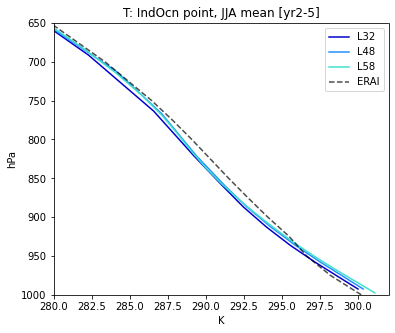

In [127]:

# plotProfiles(IOpoint_selL32, IOpoint_selL48, IOpoint_selL58, 'OMEGA',
#              IOpoint_erai, 'OMEGA', 100.0/86400.0, 
#              None, None, None, None, 
#              'IndOcn point, JJA mean [yr2-5]')

# plotProfiles(IOpoint_selL32, IOpoint_selL48, IOpoint_selL58, 'Q',
#              IOpoint_erai, 'SHUM', 1e-3, 
#              0.002, 0.02, 1000, 400, 
#              'IndOcn point, JJA mean [yr2-5]')

# plotProfiles(IOpoint_selL32, IOpoint_selL48, IOpoint_selL58, 'U',
#              IOpoint_erai, 'U', 1, 
#              -38, 15, 1000, 10, 
#              'IndOcn point, JJA mean [yr2-5]')

# plotProfiles(IOpoint_selL32, IOpoint_selL48, IOpoint_selL58, 'V',
#              IOpoint_erai, 'V', 1, 
#              -10, 8, 1000, 10, 
#              'IndOcn point, JJA mean [yr2-5]')

# plotProfiles(IOpoint_selL32, IOpoint_selL48, IOpoint_selL58, 'T',
#              IOpoint_erai, 'T', 1, 
#              None, None, None, None,
#              'IndOcn point, JJA mean [yr2-5]')

# plotProfiles(IOpoint_selL32, IOpoint_selL48, IOpoint_selL58, 'T',
#              IOpoint_erai, 'T', 1, 
#              190, 245, 300, 10,
#              'IndOcn point, JJA mean [yr2-5]')

# plotProfiles(IOpoint_selL32, IOpoint_selL48, IOpoint_selL58, 'T',
#              IOpoint_erai, 'T', 1, 
#              280, 302, 1000, 650,
#              'IndOcn point, JJA mean [yr2-5]')



In [140]:
# plotProfiles(SCSpointTop_selL32, SCSpointTop_selL48, SCSpointTop_selL58, 'OMEGA',
#              SCSpointTop_erai, 'OMEGA', 100.0/86400.0, 
#              None, None, None, None, 
#              'SCS point (top), JJA mean [yr2-5]')

# plotProfiles(SCSpointTop_selL32, SCSpointTop_selL48, SCSpointTop_selL58, 'Q',
#              SCSpointTop_erai, 'SHUM', 1e-3, 
#              0.002, 0.02, 1000, 400, 
#              'SCS point (top), JJA mean [yr2-5]')

# plotProfiles(SCSpointTop_selL32, SCSpointTop_selL48, SCSpointTop_selL58, 'U',
#              SCSpointTop_erai, 'U', 1, 
#              -28, 10, 1000, 10, 
#              'SCS point (top), JJA mean [yr2-5]')

# plotProfiles(SCSpointTop_selL32, SCSpointTop_selL48, SCSpointTop_selL58, 'V',
#              SCSpointTop_erai, 'V', 1, 
#              -8, 10, 1000, 10, 
#              'SCS point (top), JJA mean [yr2-5]')

# plotProfiles(SCSpointTop_selL32, SCSpointTop_selL48, SCSpointTop_selL58, 'T',
#              SCSpointTop_erai, 'T', 1, 
#              None, None, None, None,
#              'SCS point (top), JJA mean [yr2-5]')

# plotProfiles(SCSpointTop_selL32, SCSpointTop_selL48, SCSpointTop_selL58, 'T',
#              SCSpointTop_erai, 'T', 1, 
#              190, 245, 300, 10,
#              'SCS point (top), JJA mean [yr2-5]')

# plotProfiles(SCSpointTop_selL32, SCSpointTop_selL48, SCSpointTop_selL58, 'T',
#              SCSpointTop_erai, 'T', 1, 
#              280, 302, 1000, 650,
#              'SCS point (top), JJA mean [yr2-5]')



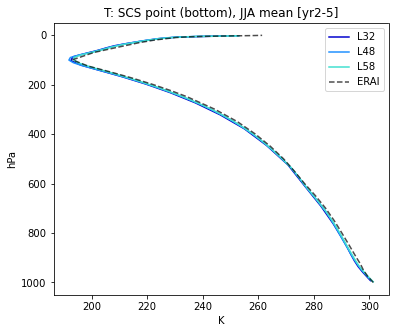

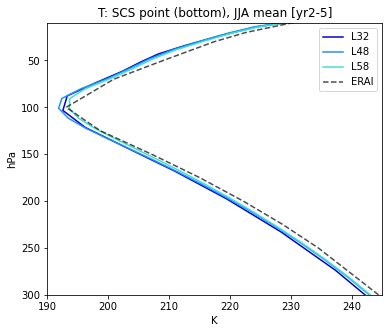

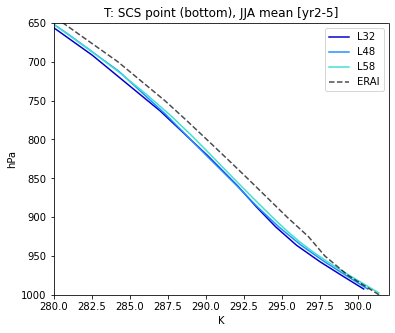

In [151]:
# plotProfiles(SCSpointBot_selL32, SCSpointBot_selL48, SCSpointBot_selL58, 'OMEGA',
#              SCSpointBot_erai, 'OMEGA', 100.0/86400.0, 
#              None, None, None, None, 
#              'SCS point (bottom), JJA mean [yr2-5]')

# plotProfiles(SCSpointBot_selL32, SCSpointBot_selL48, SCSpointBot_selL58, 'Q',
#              SCSpointTop_erai, 'SHUM', 1e-3, 
#              0.002, 0.02, 1000, 400, 
#              'SCS point (bottom), JJA mean [yr2-5]')

# plotProfiles(SCSpointBot_selL32, SCSpointBot_selL48, SCSpointBot_selL58, 'U',
#              SCSpointTop_erai, 'U', 1, 
#              -28, 12, 1000, 10, 
#              'SCS point (bottom), JJA mean [yr2-5]')

# plotProfiles(SCSpointBot_selL32, SCSpointBot_selL48, SCSpointBot_selL58, 'V',
#              SCSpointTop_erai, 'V', 1, 
#              -7, 9, 1000, 10, 
#              'SCS point (bottom), JJA mean [yr2-5]')

plotProfiles(SCSpointBot_selL32, SCSpointBot_selL48, SCSpointBot_selL58, 'T',
             SCSpointTop_erai, 'T', 1, 
             None, None, None, None,
             'SCS point (bottom), JJA mean [yr2-5]')

plotProfiles(SCSpointBot_selL32, SCSpointBot_selL48, SCSpointBot_selL58, 'T',
             SCSpointTop_erai, 'T', 1, 
             190, 245, 300, 10,
             'SCS point (bottom), JJA mean [yr2-5]')

plotProfiles(SCSpointBot_selL32, SCSpointBot_selL48, SCSpointBot_selL58, 'T',
             SCSpointTop_erai, 'T', 1, 
             280, 302, 1000, 650,
             'SCS point (bottom), JJA mean [yr2-5]')



**Time-series?**

In [176]:
# ## Select these points... 

# ## Get points that are already averaged in time too
# IOpoint_L32     = L32_h1.sel(lon=92,lat=10, method='nearest').isel(time=np.where(L32_h1['time.year']>=2)[0]).load()
# IOpoint_L48     = L48_h1.sel(lon=92,lat=10, method='nearest').isel(time=np.where(L48_h1['time.year']>=2)[0]).load()
# IOpoint_L58     = L58_h1.sel(lon=92,lat=10, method='nearest').isel(time=np.where(L58_h1['time.year']>=2)[0]).load()

# SCSpointBot_L32 = L32_h1.sel(lon=112,lat=13, method='nearest').isel(time=np.where(L32_h1['time.year']>=2)[0]).load()
# SCSpointBot_L48 = L48_h1.sel(lon=112,lat=13, method='nearest').isel(time=np.where(L48_h1['time.year']>=2)[0]).load()
# SCSpointBot_L58 = L58_h1.sel(lon=112,lat=13, method='nearest').isel(time=np.where(L58_h1['time.year']>=2)[0]).load()

# WPpoint_L32     = L32_h1.sel(lon=135,lat=12, method='nearest').isel(time=np.where(L32_h1['time.year']>=2)[0]).load()
# WPpoint_L48     = L48_h1.sel(lon=135,lat=12, method='nearest').isel(time=np.where(L48_h1['time.year']>=2)[0]).load()
# WPpoint_L58     = L58_h1.sel(lon=135,lat=12, method='nearest').isel(time=np.where(L58_h1['time.year']>=2)[0]).load()


### Wind contours?

In [186]:
L32_h1['windSpeed'] = (('time','lev','lat','lon'), 
                       np.sqrt(L32_h1.U.values**2 + L32_h1.V.values**2))

L48_h1['windSpeed'] = (('time','lev','lat','lon'), 
                       np.sqrt(L48_h1.U.values**2 + L48_h1.V.values**2))

L58_h1['windSpeed'] = (('time','lev','lat','lon'), 
                       np.sqrt(L58_h1.U.values**2 + L58_h1.V.values**2))


In [187]:
## Get a few dates to look at the monsoon onset... 

# May 20 
L32_may20 = L32_h1.isel(time=np.where((L32_h1['time.month'].values==5) & (L32_h1['time.day'].values==20) )[0])
L48_may20 = L48_h1.isel(time=np.where((L48_h1['time.month'].values==5) & (L48_h1['time.day'].values==20) )[0])
L58_may20 = L58_h1.isel(time=np.where((L58_h1['time.month'].values==5) & (L58_h1['time.day'].values==20) )[0])

# June 1 
L32_jun1 = L32_h1.isel(time=np.where((L32_h1['time.month'].values==6) & (L32_h1['time.day'].values==1) )[0])
L48_jun1 = L48_h1.isel(time=np.where((L48_h1['time.month'].values==6) & (L48_h1['time.day'].values==1) )[0])
L58_jun1 = L58_h1.isel(time=np.where((L58_h1['time.month'].values==6) & (L58_h1['time.day'].values==1) )[0])

# June 10 
L32_jun10 = L32_h1.isel(time=np.where((L32_h1['time.month'].values==6) & (L32_h1['time.day'].values==10) )[0])
L48_jun10 = L48_h1.isel(time=np.where((L48_h1['time.month'].values==6) & (L48_h1['time.day'].values==10) )[0])
L58_jun10 = L58_h1.isel(time=np.where((L58_h1['time.month'].values==6) & (L58_h1['time.day'].values==10) )[0])

# June 20
L32_jun20 = L32_h1.isel(time=np.where((L32_h1['time.month'].values==6) & (L32_h1['time.day'].values==20) )[0])
L48_jun20 = L48_h1.isel(time=np.where((L48_h1['time.month'].values==6) & (L48_h1['time.day'].values==20) )[0])
L58_jun20 = L58_h1.isel(time=np.where((L58_h1['time.month'].values==6) & (L58_h1['time.day'].values==20) )[0])



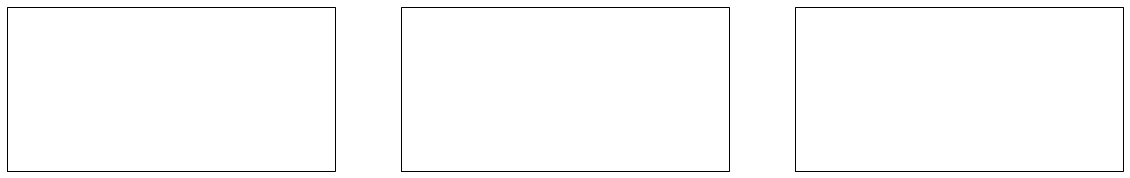

In [183]:
fig,axs = plt.subplots(1,3, figsize=(20, 4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
axs     = axs.ravel()

# plot velocity field
uvel, lonu = add_cyclic_point(L32_may20.U, coord=L32_may20.lon)
vvel, lonv = add_cyclic_point(L32_may20.V, coord=L32_may20.lon)
spd,  lons = add_cyclic_point(L32_may20, coord=L32_may20.lon)

lonu = np.where(lonu>=180.,lonu-360.,lonu)

strm=ax.streamplot(lonu, gustU.lat.values, 
                   uvel[levSel,:,:], vvel[levSel,:,:], 
                   density=5,
                   color=spd[levSel,:,:], 
                   cmap='autumn', 
                   transform=ccrs.PlateCarree())
cbar = fig.colorbar(strm.lines, orientation='horizontal',pad=0.04, aspect=50, shrink=0.75)
cbar.set_label(gustU['U'].units,fontsize=14)

ax.set_title('Gust\nJJA-mean Streamlines at '+str(gustU.lev.values[levSel])+' hPa', fontsize=16)
ax.coastlines()



In [ ]:
###### fig = plt.figure(figsize=(20, 10))
ax  = plt.axes(projection=ccrs.PlateCarree())

levSel = 1

# plot velocity field
uvel, lonu = add_cyclic_point(gustU_meanJJA.U, coord=gustU_meanJJA.lon)
vvel, lonv = add_cyclic_point(gustV_meanJJA.V, coord=gustV_meanJJA.lon)
spd,  lons = add_cyclic_point(gustSpeed_meanJJA, coord=gustV_meanJJA.lon)

lonu = np.where(lonu>=180.,lonu-360.,lonu)

strm=ax.streamplot(lonu, gustU.lat.values, 
                   uvel[levSel,:,:], vvel[levSel,:,:], 
                   density=5,
                   color=spd[levSel,:,:], 
                   cmap='autumn', 
                   transform=ccrs.PlateCarree())
cbar = fig.colorbar(strm.lines, orientation='horizontal',pad=0.04, aspect=50, shrink=0.75)
cbar.set_label(gustU['U'].units,fontsize=14)

ax.set_title('Gust\nJJA-mean Streamlines at '+str(gustU.lev.values[levSel])+' hPa', fontsize=16)
ax.coastlines()

# ax.set_extent([50, 180, -20, 55], crs=ccrs.PlateCarree())